In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import cv2
from tqdm.notebook import tqdm

from fastai.vision.all import *
from fastai.vision import models
import torch

import sys
sys.path.append('../')
from src.types.tensor_tiles import FluorescenceTile
from src.stats_reader import DataStats
from src.transforms.augmentations import PairAugmentations
from src.types.fluorescence_tuple import FluorescenceTuple
from src.transforms.contrastive_transform import ContrastiveFluorescenceTransform
from src.models.loss_model import get_loss_model_vgg, siamese_splitter

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
bs = 4
zoom = 60
stats_path = '../configs/data_statistics.json'
STATS = DataStats(stats_path, zoom)

path = '../input/tile_set/'
df = pd.read_csv(os.path.join(path, f'train_{zoom}.csv'))
df.head()

,fn,fold,slide_name,start_x,start_y,tile_sz,slide_width,slide_height,target_fn
0,input_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__0.npy,0,AssayPlate_Greiner_#655090_B03_T0001F001L01,0,0,256,2556,2156,target_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__0.npy
1,input_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__192.npy,0,AssayPlate_Greiner_#655090_B03_T0001F001L01,0,192,256,2556,2156,target_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__192.npy
2,input_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__384.npy,0,AssayPlate_Greiner_#655090_B03_T0001F001L01,0,384,256,2556,2156,target_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__384.npy
3,input_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__576.npy,0,AssayPlate_Greiner_#655090_B03_T0001F001L01,0,576,256,2556,2156,target_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__576.npy
4,input_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__768.npy,0,AssayPlate_Greiner_#655090_B03_T0001F001L01,0,768,256,2556,2156,target_60_256/AssayPlate_Greiner_#655090_B03_T0001F001L01__0__768.npy


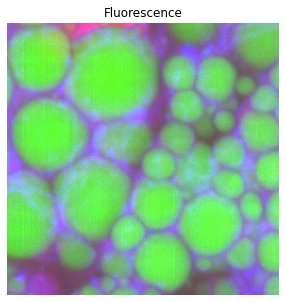

In [4]:
targ = FluorescenceTile.create(os.path.join(path, df.iloc[100].target_fn), STATS)
targ.show();

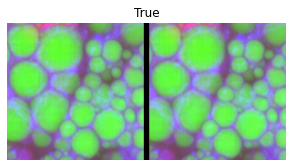

In [5]:
s = FluorescenceTuple(targ, targ, True)
s.show();

In [6]:
train_fluorescence_paths = [os.path.join(path, fn) for fn, fold in zip(df.target_fn.values, df.fold.values) if fold != 0]
valid_fluorescence_paths = [os.path.join(path, fn) for fn, fold in zip(df.target_fn.values, df.fold.values) if fold == 0]

augmentations = PairAugmentations()

In [7]:
train_tl= TfmdLists(range(len(train_fluorescence_paths)), ContrastiveFluorescenceTransform( 
    train_fluorescence_paths,
    stats=STATS,
    augment_func=augmentations,
    is_valid=False
))

In [8]:
valid_tl= TfmdLists(range(len(valid_fluorescence_paths)), ContrastiveFluorescenceTransform( 
    valid_fluorescence_paths,
    stats=STATS,
    augment_func=augmentations,
    is_valid=True
))

In [9]:
len(train_fluorescence_paths), len(valid_fluorescence_paths)

(12768, 3360)

In [10]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=4)
dls = dls.cuda()

In [11]:
@typedispatch
def show_batch(x:FluorescenceTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): FluorescenceTuple(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

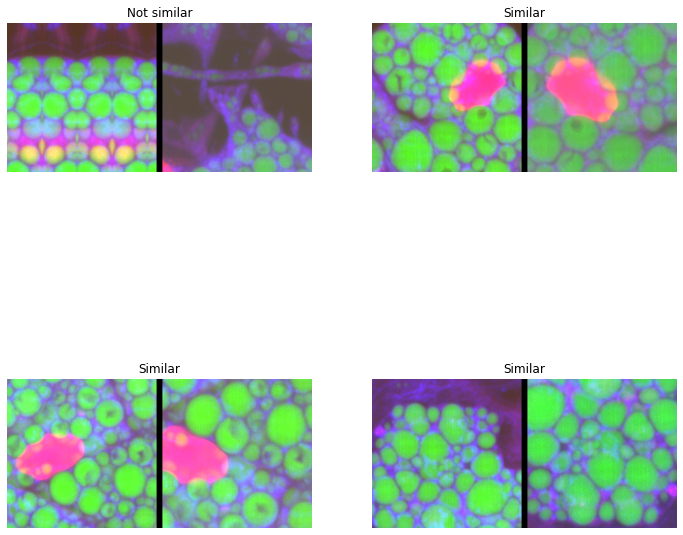

In [12]:
dls.show_batch()

In [13]:
model = get_loss_model_vgg()

In [14]:
learn = Learner(dls,
                model, 
                loss_func=CrossEntropyLossFlat(), 
                splitter=siamese_splitter, 
                metrics=accuracy)

In [15]:
learn.freeze()

SuggestedLRs(lr_min=5.754399353463669e-07, lr_steep=1.9054607491852948e-06)

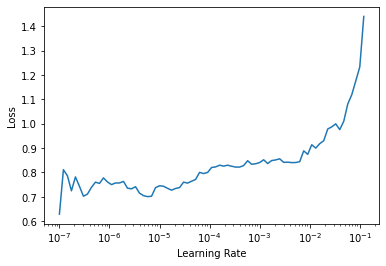

In [16]:
learn.lr_find()

In [17]:
@typedispatch
def show_results(x:FluorescenceTuple, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        FluorescenceTuple(x[0][i], x[1][i], title).show(ctx=ctx)

In [18]:
# train the head
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.724666,0.622218,0.648810,02:23
1,0.734802,0.545320,0.718750,02:23
2,0.698717,0.572969,0.675000,02:23
3,0.658165,0.495681,0.772024,02:23
4,0.618789,0.437368,0.803869,02:22
5,0.687143,0.392432,0.843155,02:23
6,0.592747,0.388346,0.842857,02:25
7,0.576327,0.374021,0.847024,02:24
8,0.599384,0.329008,0.880357,02:24
9,0.566868,0.341567,0.884226,02:22


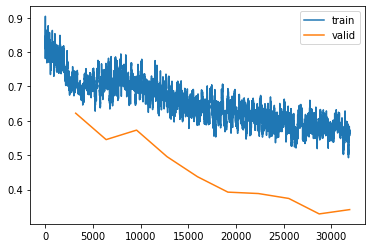

In [19]:
learn.recorder.plot_loss()

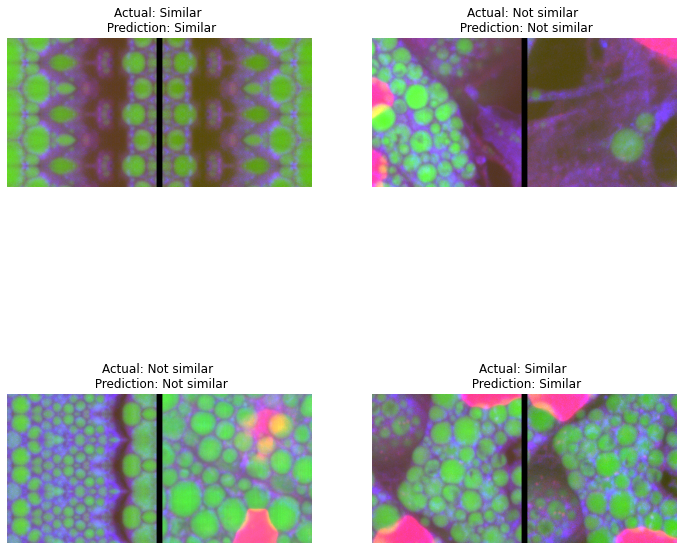

In [20]:
learn.show_results()

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(20, slice(1e-5,5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.609906,0.368693,0.855952,03:12
1,0.552750,0.393277,0.825298,03:12
2,0.577301,0.408561,0.811607,03:12
3,0.617244,0.378677,0.849702,03:12
4,0.601268,0.368154,0.843750,03:12
5,0.592742,0.350721,0.855357,03:11
6,0.601371,0.414725,0.816071,03:12
7,0.588926,0.366788,0.841369,03:12
8,0.575965,0.327770,0.866964,03:12
9,0.562450,0.345472,0.857143,03:12


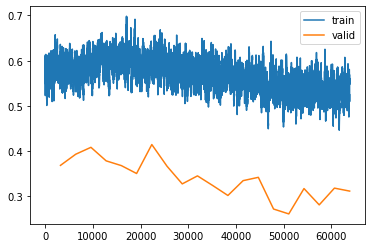

In [23]:
learn.recorder.plot_loss()

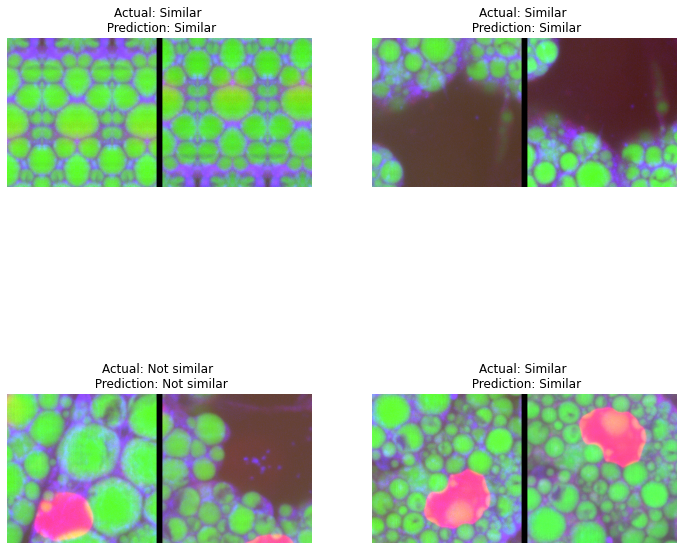

In [24]:
learn.show_results()

In [26]:
#torch.save(model.state_dict(),'../models/vgg16_20201105_zoom60_siamese.pth')

In [27]:
#learn.fit_one_cycle(20, slice(1e-5,5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.546114,0.219140,0.919345,03:24
1,0.558195,0.249931,0.891964,03:24
2,0.541809,0.258979,0.900595,03:40
3,0.534242,0.232632,0.917560,03:44
4,0.494954,0.264311,0.891667,03:45
5,0.587190,0.324089,0.863988,03:45
6,0.532679,0.320976,0.866667,03:44
7,0.590513,0.344987,0.851488,03:48
8,0.561719,0.344522,0.849702,03:44
9,0.573995,0.341742,0.854167,03:43


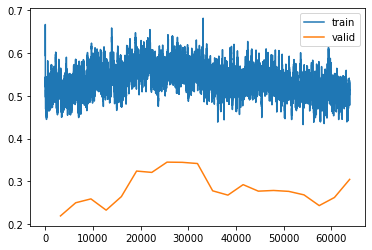

In [28]:
learn.recorder.plot_loss()

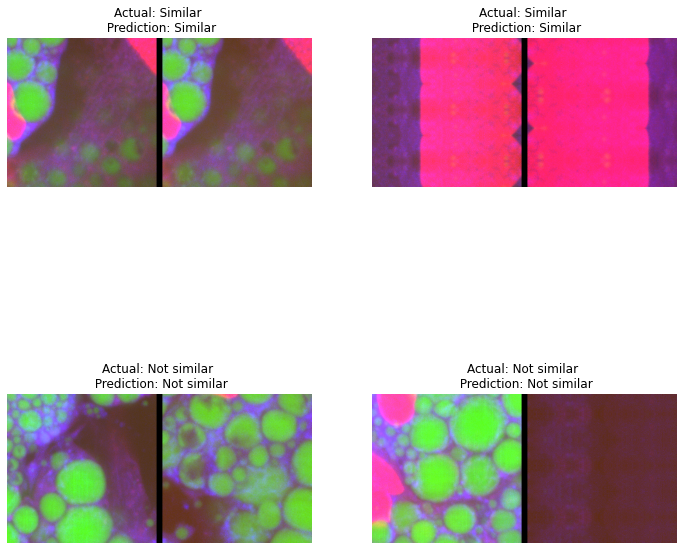

In [29]:
learn.show_results()